In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


## Read in the family information and sample submission

In [3]:
fpath = 'family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = 'sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

In [4]:
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [5]:
submission.head()

,assigned_day
family_id,
0,100
1,99
2,98
3,97
4,96


## Exploring the Family Data

In [6]:
# Setting base date as Christmas Eve
import datetime
base = datetime.datetime(2019,12,24,00)

# Creating datelist for all 100 days before christmas
date_list = [base - datetime.timedelta(days=x) for x in range(100)]

In [7]:
# Creating date dataframe with day of week number (0 = Monday)
date_index = pd.DataFrame(date_list,columns=['date'])
date_index['day'] = date_index['date'].apply(lambda x: x.dayofweek)
date_index.index += 1 #aligning the index to days before Xmas
date_index[:5]

,date,day
1,2019-12-24,1
2,2019-12-23,0
3,2019-12-22,6
4,2019-12-21,5
5,2019-12-20,4


## I need to create some functions to help approxiate cost and stay within the bounds

In [8]:
# Given cost function for families not getting their desired preferences
def top_pref_penalty(pref,d):
    
    penalty = 0
    n = pref
    
    d = d
    if pref > 0:
        if d == 0:
            penalty += 0
        elif d == 1:
            penalty += 50
        elif d == 2:
            penalty += 50 + 9 * n
        elif d == 3:
            penalty += 100 + 9 * n
        elif d == 4:
            penalty += 200 + 9 * n
        elif d == 5:
            penalty += 200 + 18 * n
        elif d == 6:
            penalty += 300 + 18 * n
        elif d == 7:
            penalty += 300 + 36 * n
        elif d == 8:
            penalty += 400 + 36 * n
        elif d == 9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n
    else:
        pass
        
    return penalty

In [ ]:
# # Daily limit function to ensure all days have at least 125 people and at most 300 
# # (can mess with parameters to change cost)
# def daily_limit(family_id,choice,n_people,pref,n):
    
#     # Looping through all family choices until finding match and ensuring buckets get filled to n at least
#     if occupancy.loc[choice]['total'] + n_people <= n and pref <= 3:
        
#         occupancy.loc[choice]['pref_{}'.format(pref)] += n_people
#         occupancy.loc[choice]['total'] += n_people
        
#         submission.loc[family_id]['assigned_day'] = choice.astype('int')
#         submission.loc[family_id]['pref'] = pref
        
#         return 1 # Should stop iterating when adding to occupancy df

#     # Force people into smaller buckets for their 7th thru 9th choice if breaking daily limit rules
#     elif pref >= 7:
        
#         # Current smallest buckets in Occupancy dataframe
#         current_smallest = pd.DataFrame(occupancy['total'].nsmallest(10))
        
#         # Should be 7 every time
#         pref = pref
        
#         # Loop through final 3 choices and put in smallest bucket if possible
#         for i in data.iloc[family_id][['choice_7','choice_8','choice_9']].values:
            
#             # Loop through Pref 7 to 9 days in order and see if in smallest 10 buckets
#             if i in list(current_smallest.index.values):
#                 occupancy.loc[i]['pref_{}'.format(pref)] += n_people
#                 occupancy.loc[i]['total'] += n_people
                
#                 submission.loc[family_id]['assigned_day'] = choice.astype('int')
#                 submission.loc[family_id]['pref'] = i
                
#                 return 1 # Should stop iterating when adding to occupancy df
#                 break
                
#             # If current pref is not is smallest list, go to next and try again
#             else:
#                 pref += 1
#                 pass
            
#         # If we get through all choices and don't fill smallest buckets, put into smallest bucket    
#         if pref == 10:
            
#             smallest_day = list(current_smallest.index.values)[0]
            
#             occupancy.loc[smallest_day]['pref_{}'.format(10)] += n_people
#             occupancy.loc[smallest_day]['total'] += n_people
            
#             submission.loc[family_id]['assigned_day'] = choice.astype('int')
#             submission.loc[family_id]['pref'] = pref
            
#             return 1 #Should stop iterating when adding to occupancy df
        
#     else:
#         return 0 #Should continue iterating through choices when buckets need to be filled

In [110]:
# Daily limit function to ensure all days have at least 125 people and at most 300 
# (can mess with parameters to change cost)
def daily_limit(family_id,choice,n_people,pref,n,remaining):
    
    bucket_total = occupancy.loc[choice]['total']
    
    if choice == 100:
        pre_bucket_total = 0
    else:
        pre_bucket_total = occupancy.loc[choice+1]['total']
    
#     if choice == 1:
#         post_bucket_total = 300
#     else:
    post_bucket_total = occupancy.loc[choice-1]['total']
    
    
    # Looping through all family choices until finding match and ensuring buckets get filled to n at least
    if (occupancy.loc[choice]['total'] + n_people <= 300 and\
        remaining > occupancy[occupancy['total'] < 125]['total'].sum() + n_people and\
        abs(occupancy.loc[choice]['total'] + n_people - pre_bucket_total) <= 25 and\
        abs(occupancy.loc[choice]['total'] + n_people - post_bucket_total) <= 25 \
       ):
        
        # Counting in Occupancy Dataframe
        occupancy.loc[choice]['pref_{}'.format(pref)] += n_people
        occupancy.loc[choice]['total'] += n_people
        
        # Adding submission
        submission.loc[family_id]['assigned_day'] = choice.astype('int')
        submission.loc[family_id]['pref'] = pref
        
        # I do not want to constrain Day 0
        if choice == 1:
            occupancy.loc[0]['pref_{}'.format(pref)] += n_people
            occupancy.loc[0]['total'] += n_people
        
        return 1
    
    elif pref >= 9:
        
        current_smallest = pd.DataFrame(occupancy['total'].nsmallest(10))
        smallest_day = list(current_smallest.index.values)[0]
        
        occupancy.loc[smallest_day]['pref_{}'.format(10)] += n_people
        occupancy.loc[smallest_day]['total'] += n_people

        submission.loc[family_id]['assigned_day'] = choice.astype('int')
        submission.loc[family_id]['pref'] = pref
            
        return 1 #Should stop iterating when adding to occupancy df
        
    else:
        return 0
        

## Assigning Days Based off Preference and Daily Occupancy Limits (initial evaluation):

In [111]:
# Testing logic for dynamically looking at choices
n = 225

# Creating occupancy dataframe to capture daily attendance by preference
columns = ['pref_0', 'pref_1', 'pref_2', 'pref_3', 'pref_4', 'pref_5',
       'pref_6', 'pref_7', 'pref_8', 'pref_9','pref_10','total']
occupancy = pd.DataFrame(0,index=range(0,101),columns=columns)

# Create submission dataframe
submission = pd.DataFrame(data.copy(deep=True),columns=['assigned_day','pref'])

remaining = 20968 # total number of people

for index,row in data.iterrows():
    for i in range(10):
        choice = row['choice_{}'.format(i)]
        n_people = row['n_people']
        family_id = index
        pref = i
        
        # Runs occupancy filling function from highlest to lowest preference
        add_check = daily_limit(family_id,choice,n_people,pref,n,remaining)
        
        if add_check == 1:
            remaining -= n_people
            break

        if add_check == 0:
            pass
        else:
            assert False, 'Error with add_check'

In [112]:
occupancy['total'].min(), occupancy['total'].max()

(130, 300)

In [113]:
submission['n_people'] = data['n_people']
sub_agg = submission[['assigned_day','n_people']].groupby('assigned_day').sum()
sub_agg['n_people'].min(),sub_agg['n_people'].max()

(29, 339)

In [114]:
missing = data.loc[submission[submission['pref'].isnull()].index]
missing

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,


In [39]:
for index,row in missing.iterrows():
    for i in range(10):
        choice = row['choice_{}'.format(i)]
        n_people = row['n_people']
        family_id = index
        pref = i
        
        
        
    
    

In [115]:
# Initializing Preference Penalty Cost column by day
occupancy['pref_pen'] = 0

# Apply preference penalty across all preference columns (pref_#) and sums to one column
for i in range(11):
    occupancy['pref_pen'] += occupancy.apply(lambda x: top_pref_penalty(x['pref_{}'.format(i)],i),axis=1)

In [116]:
occupancy.head()

,pref_0,pref_1,pref_2,pref_3,pref_4,pref_5,pref_6,pref_7,pref_8,pref_9,pref_10,total,pref_pen
0,198,57,15,18,4,3,5,0,0,0,0,300,1377
1,198,57,15,18,4,3,5,0,0,0,0,300,1377
2,165,37,34,24,15,12,4,7,0,0,0,298,2397
3,184,42,29,18,10,17,0,0,0,0,0,300,1419
4,172,33,36,19,13,11,0,0,6,0,0,290,2026


## Plotting Preference Given By Day Before Xmas:
##### Plotting preference by day after initial run shows most people are getting a better preference near Xmas (most likely due to the volume of preferences on those days), but the further we move away, more people are being added to non-requested days to account for minimum daily volumes of 125 people. Also, weekdays have high percentages of no preference given, which is very expensive

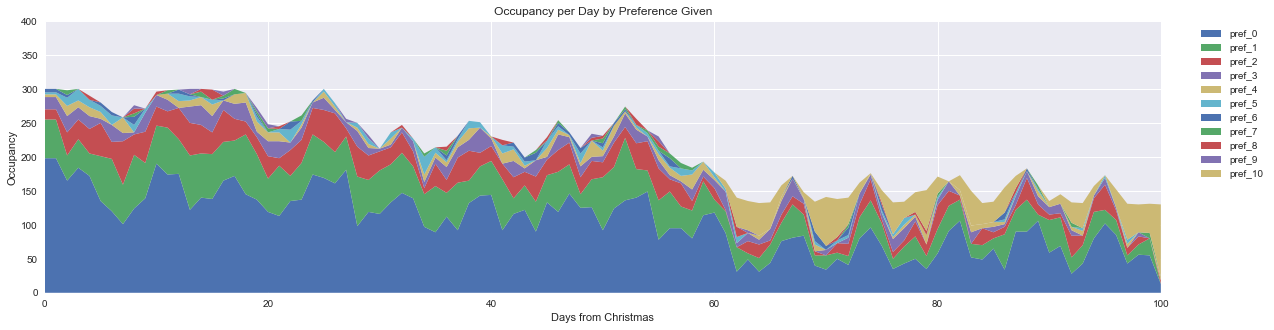

In [117]:
plt.close('all')
plt.style.use('seaborn')

# Labels for stacked plot
labels = list(occupancy.columns)[:11]

# Creating individual lists for each preference (required for stacked plot)
pref_0 = list(occupancy['pref_0'].values)
pref_1 = list(occupancy['pref_1'].values)
pref_2 = list(occupancy['pref_2'].values)
pref_3 = list(occupancy['pref_3'].values)
pref_4 = list(occupancy['pref_4'].values)
pref_5 = list(occupancy['pref_5'].values)
pref_6 = list(occupancy['pref_6'].values)
pref_7 = list(occupancy['pref_7'].values)
pref_8 = list(occupancy['pref_8'].values)
pref_9 = list(occupancy['pref_9'].values)
pref_10 = list(occupancy['pref_10'].values)

# Getting days from Occupancy dataframe
x = list(occupancy.index.values)

# Setting figure
fig, ax = plt.subplots(figsize=(20,5))

# Formatting plot area
ax.set_xlabel('Days from Christmas')
ax.set_ylabel('Occupancy')
ax.set_ylim(0,400)
ax.set_xlim(0,100)

# Creating plot
ax.stackplot(x,pref_0,pref_1,pref_2,pref_3,pref_4,pref_5,pref_6,pref_7,pref_8,pref_9,pref_10,labels=labels)
ax.legend(loc=1,bbox_to_anchor=(1.1, 1))
ax.set_title('Occupancy per Day by Preference Given')

plt.show()

## Accounting cost for all days:
##### Accounting costs grow exponentially when the gap between daily volumes is large, as we see with the days further way from Xmas

In [118]:
occupancy['acct_cost'] = 0
days = list(range(1,101,1))

# First day is special
occupancy.loc[days[0]]['acct_cost'] = (occupancy.loc[days[0]]['total']-125.0) / 400.0 *\
                                       occupancy.loc[days[0]]['total']**(0.5)

# Loop over the rest of the days, keeping track of previous count
yesterday_count = occupancy.loc[days[0]]['total']
for day in days[1:]:

    today_count = occupancy.loc[day]['total']
    diff = abs(today_count - yesterday_count)
    occupancy.loc[day]['acct_cost'] = max(0., (occupancy.loc[day]['total']-125.0) / 400.0 *\
                                              occupancy.loc[day]['total']**(0.5 + diff / 50.0))
    yesterday_count = today_count

occupancy.tail()

,pref_0,pref_1,pref_2,pref_3,pref_4,pref_5,pref_6,pref_7,pref_8,pref_9,pref_10,total,pref_pen,acct_cost
96,85,22,14,4,0,0,0,0,0,0,27,152,12580,6
97,43,12,11,0,6,6,0,0,0,0,53,131,24263,1
98,56,15,12,6,0,0,0,0,0,0,41,130,18656,0
99,55,25,0,0,0,0,0,8,0,0,43,131,19800,0
100,13,0,5,0,6,0,0,0,0,0,106,130,46853,0


In [119]:
# First day accounting cost (Just checking logic)
np.round(max(0,(300-125.0) / 400.0 * 300**(0.5)),2)

7.58

## Summarizing Cost and Creating Initial Submission:
##### Initial submission estimated cost of 710K is lower than the scored cost of 943K

In [120]:
occupancy['total_cost'] = occupancy['pref_pen'] + occupancy['acct_cost']
score = occupancy['total_cost'].sum()
submission['assigned_day'] = pd.to_numeric(submission['assigned_day']).astype('int')
submission['pref'] = pd.to_numeric(submission['pref']).astype('int')

submission[['assigned_day']].to_csv(f'submission_{score}.csv')
submission.to_csv(f'submission_data_{score}.csv')
print('{0:,}'.format(score))

686,928


<BarContainer object of 100 artists>

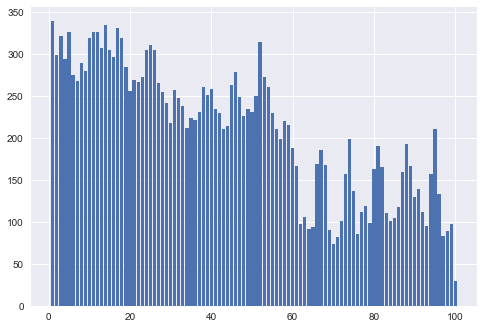

In [121]:
plt.bar(list(sub_agg['n_people'].index),list(sub_agg['n_people'].values))

# Code from starter book

## Create some lookup dictionaries and define constants

You don't need to do it this way. :-)

In [ ]:
family_size_dict = data[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

## Cost Function
Very un-optimized  ;-)

In [ ]:
def cost_function(prediction):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}

    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n

    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count

    penalty += accounting_cost

    return penalty

## Simple Opimization Approach

For each family, loop over their choices, and if keep it if the score improves. There's a lot of easy improvement that can be made to this code.

In [ ]:
# Start with the sample submission values
best = submission['assigned_day'].tolist()
start_score = cost_function(best)

new = best.copy()
# loop over each family
for fam_id, _ in enumerate(best):
    # loop over each family choice
    for pick in range(10):
        day = choice_dict[f'choice_{pick}'][fam_id]
        temp = new.copy()
        temp[fam_id] = day # add in the new pick
        if cost_function(temp) < start_score:
            new = temp.copy()
            start_score = cost_function(new)

submission['assigned_day'] = new
score = cost_function(new)
submission.to_csv(f'submission_{score}.csv')
print(f'Score: {score}')

# Scrap

In [ ]:
# Creating my empty occupancy dataframe for controlling limits
occupancy = pd.DataFrame(0,index=date_index.index,columns=['occ_count'])
occupancy

In [ ]:
# Creating trimmed dataframe of non-peak requests (Mon-Thur) and non-Xmas Eve
non_weekend_or_xmas = data.where(~data.choice_0_day.isin([4,5,6])&data.choice_0_day != 1).dropna()
non_weekend_or_xmas.head()

In [ ]:
# Adding non-peak requests to occupancy dataframe
for index,row in non_weekend_or_xmas.iterrows():
    occupancy['occ_count'][row['choice_0']] += row['n_people']
#     print(index,row['n_people'])

In [ ]:
# loops = 100
# for i in range(100):
#     data['picked_choice_{}'.format(i)] = 10
#     data['picked_day_{}'.format(i)] = -2
    